## This notebook creates the principal component tables (components, DCM, loadings) and visualizations

In [60]:
import pandas as pd
import numpy as np
from scipy.linalg import norm, eigh
from sklearn.decomposition import PCA
import plotly_express as px

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Config 

In [61]:
import configparser
config = configparser.ConfigParser()
config.read("../../env.ini")
data_home  = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

## Data 

In [62]:
tfidf_reduced = pd.read_csv(f"{output_dir}/tfidf_reduced_L2.csv").set_index(['personid','session'])
lib = pd.read_csv(f"{output_dir}/library_personbysession.csv").set_index(['personid','session'])
vocab = pd.read_csv(f"{output_dir}/vocab.csv").set_index(['term_str'])
dtcm = pd.read_csv(f"{output_dir}/dtcm.csv")

In [63]:
lib.head(5)

objective  unpacking  selfinstruction  selfregulation  \
personid    session                                                          
JMU_F22_002 0.0       1.166667   1.666667         1.000000        1.000000   
            1.0       1.000000   1.333333         1.000000        1.500000   
JMU_F22_005 0.0       1.166667   1.833333         1.333333        1.000000   
            1.0       1.500000   1.666667         1.500000        1.166667   
JMU_F22_009 0.0       1.250000   2.000000         1.000000        1.000000   

                     ending  accuracy  avg_score  \
personid    session                                
JMU_F22_002 0.0        1.00  2.333333   1.361111   
            1.0        1.00  1.666667   1.250000   
JMU_F22_005 0.0        1.00  2.000000   1.388889   
            1.0        1.00  1.833333   1.444444   
JMU_F22_009 0.0        1.25  1.750000   1.375000   

                                             metadata site course  \
personid    session                                                 
JMU_F22_002 0.0       Tue, Oct 18, 2022 3:32PM • 4:46  JMU    F22   
            1.0      Tue, Dec 20, 2022 11:08AM • 2:36  JMU    F22   
JMU_F22_005 0.0       Tue, Oct 18, 2022 3:33PM • 5:00  JMU    F22   
            1.0      Tue, Dec 20, 2022 11:08AM • 2:57  JMU    F22   
JMU_F22_009 0.0       Tue, Oct 18, 2022 3:34PM • 4:54  JMU    F22   

                     treatment_status  
personid    session                    
JMU_F22_002 0.0      Non-Experimental  
            1.0      Non-Experimental  
JMU_F22_005 0.0      Non-Experimental  
            1.0      Non-Experimental  
JMU_F22_009 0.0      Non-Experimental

In [64]:
tfidf_reduced.head(5)

put      says   looking     solve     total  \
personid    session                                                     
JMU_F22_002 0.0      0.052812  0.041575  0.025465  0.000000  0.033090   
            1.0      0.011206  0.167684  0.019795  0.000000  0.000000   
JMU_F22_005 0.0      0.039944  0.043195  0.180225  0.062317  0.094433   
            1.0      0.037452  0.039099  0.026261  0.100520  0.070650   
JMU_F22_009 0.0      0.105650  0.067147  0.036015  0.000000  0.036286   

                         take       way       has    trying    little  ...  \
personid    session                                                    ...   
JMU_F22_002 0.0      0.010144  0.043924  0.015430  0.000000  0.000000  ...   
            1.0      0.000000  0.045848  0.000000  0.000000  0.000000  ...   
JMU_F22_005 0.0      0.039563  0.133106  0.029186  0.075725  0.046198  ...   
            1.0      0.000000  0.027131  0.008925  0.130921  0.000000  ...   
JMU_F22_009 0.0      0.116627  0.000000  0.033840  0.037481  0.018881  ...   

                     others  symbol  meet  bat  tackle  fours  task  activity  \
personid    session                                                             
JMU_F22_002 0.0         0.0     0.0   0.0  0.0     0.0    0.0   0.0       0.0   
            1.0         0.0     0.0   0.0  0.0     0.0    0.0   0.0       0.0   
JMU_F22_005 0.0         0.0     0.0   0.0  0.0     0.0    0.0   0.0       0.0   
            1.0         0.0     0.0   0.0  0.0     0.0    0.0   0.0       0.0   
JMU_F22_009 0.0         0.0     0.0   0.0  0.0     0.0    0.0   0.0       0.0   

                     ago  demonstrate  
personid    session                    
JMU_F22_002 0.0      0.0          0.0  
            1.0      0.0          0.0  
JMU_F22_005 0.0      0.0          0.0  
            1.0      0.0          0.0  
JMU_F22_009 0.0      0.0          0.0  

[5 rows x 1000 columns]

In [65]:
tfidf_reduced[tfidf_reduced.isna().any(axis=1)]

,,put,says,looking,solve,total,take,way,has,trying,little,...,others,symbol,meet,bat,tackle,fours,task,activity,ago,demonstrate
personid,session,,,,,,,,,,,,,,,,,,,,,
UD_F22_055,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
tfidf_reduced = tfidf_reduced.dropna()

## PCA 

In [67]:
#PCA FUNCTION 
def get_pca(TFIDF, 
            k=10, 
            norm_docs=True,
            norm_level=2,
            center_by_mean=True, 
            center_by_variance=False):
    
    # if TFIDF.isna().sum().sum():
    #     print("Filled NA")
    #     TFIDF = TFIDF.fillna(0)
    
    if norm_docs:
        # TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0)
        TFIDF = (TFIDF.T / norm(TFIDF, 2, axis=1)).T
    
    if center_by_mean:
        TFIDF = TFIDF - TFIDF.mean()
        
    if center_by_variance:
        TFIDF = TFIDF / TFIDF.std()        

    COV = TFIDF.cov()

    eig_vals, eig_vecs = eigh(COV)
    
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
        
    EIG_IDX = EIG_VAL.eig_val.sort_values(ascending=False).head(k)
    
    COMPS = EIG_VEC[EIG_IDX.index].T
    COMPS.index = [i for i in range(COMPS.shape[0])]
    COMPS.index.name = 'pc_id'
    

    LOADINGS = COMPS.T

    DCM = TFIDF.dot(LOADINGS)
    
    COMPINF = pd.DataFrame(index=COMPS.index)

    for i in range(k):
        for j in [0, 1]:
            top_terms = ' '.join(LOADINGS.sort_values(i, ascending=bool(j)).head(5).index.to_list())
            COMPINF.loc[i, j] = top_terms
    COMPINF = COMPINF.rename(columns={0:'pos', 1:'neg'})
    
    COMPINF['eig_val'] = EIG_IDX.reset_index(drop=True).to_frame()
    COMPINF['exp_var'] = COMPINF.eig_val / COMPINF.eig_val.sum()
    
    return LOADINGS, DCM, COMPINF

In [68]:
n_comps = 10
center_by_mean=True
center_by_variance=False
LOADINGS, DCM, COMPINF = get_pca(tfidf_reduced, 
                                 norm_docs=True, 
                                 norm_level=2, 
                                 center_by_mean=center_by_mean, 
                                 center_by_variance=center_by_variance)

In [69]:
LOADINGS.sort_index()

pc_id,0,1,2,3,4,5,6,7,8,9
term_str,,,,,,,,,,
12345678910,-0.000734,-0.007664,0.002018,0.002310,-0.024895,0.016399,-0.021261,-0.033432,0.034821,-0.000241
able,0.003259,-0.007776,-0.002159,0.006055,0.003032,0.034090,-0.025419,-0.006260,-0.011712,0.017996
according,-0.006311,0.001090,-0.012132,-0.017445,0.007759,-0.001549,-0.011416,-0.016649,-0.008038,-0.003292
account,-0.002170,0.008806,-0.000952,-0.003186,0.002807,0.014426,0.008034,0.058570,-0.000710,-0.031128
ace,-0.059476,-0.028563,0.053152,-0.070613,0.164781,-0.134752,0.066048,-0.004460,0.038204,-0.064823
...,...,...,...,...,...,...,...,...,...,...
yep,0.011433,0.035140,0.013894,0.049727,0.017127,0.013754,0.023569,0.002995,0.007343,0.007657
yet,-0.003020,0.023186,-0.015315,0.028039,0.000857,-0.013656,0.021214,0.020379,0.015143,-0.048275
younger,-0.010059,-0.004849,-0.005255,-0.003388,-0.010431,0.005652,0.004266,-0.006065,0.015216,0.005699


In [70]:
DCM

pc_id                       0         1         2         3         4  \
personid    session                                                     
JMU_F22_002 0.0     -0.306740 -0.098149  0.114683  0.149703  0.021101   
            1.0      0.408326 -0.299430  0.168382  0.051834  0.051842   
JMU_F22_005 0.0     -0.337981 -0.133178 -0.090269  0.169782 -0.077044   
            1.0      0.323920 -0.245756  0.028460  0.083493 -0.005626   
JMU_F22_009 0.0     -0.400235 -0.116671  0.025029  0.039661 -0.150547   
...                       ...       ...       ...       ...       ...   
UVA_S23_026 1.0      0.073250  0.184997  0.059858 -0.298750 -0.116790   
            2.0      0.126795  0.313036  0.137204  0.249433  0.175126   
UVA_S23_027 0.0     -0.300295 -0.101352 -0.016746  0.154908  0.054287   
            1.0      0.366192 -0.268819 -0.000989 -0.028066  0.044091   
            2.0      0.129051  0.277312 -0.000042  0.086136  0.024318   

pc_id                       5         6         7         8         9  
personid    session                                                    
JMU_F22_002 0.0     -0.025828  0.078490  0.018023 -0.106262  0.007777  
            1.0      0.011997  0.091842  0.021551 -0.006849 -0.018559  
JMU_F22_005 0.0     -0.072884 -0.067575 -0.037367 -0.047386 -0.078290  
            1.0     -0.132908 -0.099726 -0.051558 -0.025440 -0.000716  
JMU_F22_009 0.0      0.103229 -0.063880 -0.042177  0.056614  0.006559  
...                       ...       ...       ...       ...       ...  
UVA_S23_026 1.0      0.054773 -0.068287  0.048092 -0.012540  0.055374  
            2.0      0.013446 -0.001039  0.042564  0.039687 -0.047637  
UVA_S23_027 0.0      0.075205 -0.104561  0.035134 -0.111080  0.039614  
            1.0     -0.025467  0.009088  0.028627 -0.051732  0.010127  
            2.0      0.004882  0.031724 -0.011292 -0.004881  0.118978  

[473 rows x 10 columns]

In [71]:
COMPINF

,pos,neg,eig_val,exp_var
pc_id,,,,
0,ate tenths pieces more eat,eighths brown white older cups,0.077722,0.395201
1,guys good right did money,ate tenths eighths brown white,0.041587,0.211464
2,times minus place denominator subtract,white brown quantities thinking information,0.013691,0.069617
3,eighths right did pieces got,cups pencils gap older ace,0.012147,0.061767
4,minus older ace times subtraction,eighths pieces candy circles pencils,0.010837,0.055102
5,eighths tenths circles money age,pieces candy brown cups white,0.009596,0.048793
6,brown times white tenths pencils,age older pieces candy difference,0.008265,0.042024
7,money cents candy spent spend,pencils circles cups colored many,0.007981,0.040582
8,cups circles did cents drew,pencils colored part times class,0.007600,0.038645


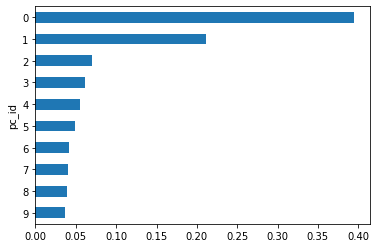

In [72]:
COMPINF.exp_var.sort_values().plot.barh();

## Create DOC

In [73]:
doc = pd.DataFrame(index=tfidf_reduced.index).join(lib)

In [74]:
doc = doc.reset_index()

In [75]:
doc['treatment_by_session'] = doc['treatment_status'].astype(str) + '_' + doc['session'].astype(str)
doc['mean_score_session'] = doc.groupby('session')['avg_score'].transform('mean')
doc['score_above_mean'] = np.where(doc['avg_score'] > doc['mean_score_session'], 1, 0)

In [76]:
doc.head(5)

,personid,session,objective,unpacking,selfinstruction,selfregulation,ending,accuracy,avg_score,metadata,site,course,treatment_status,treatment_by_session,mean_score_session,score_above_mean
0,JMU_F22_002,0.0,1.166667,1.666667,1.000000,1.000000,1.00,2.333333,1.361111,"Tue, Oct 18, 2022 3:32PM • 4:46",JMU,F22,Non-Experimental,Non-Experimental_0.0,1.322362,1
1,JMU_F22_002,1.0,1.000000,1.333333,1.000000,1.500000,1.00,1.666667,1.250000,"Tue, Dec 20, 2022 11:08AM • 2:36",JMU,F22,Non-Experimental,Non-Experimental_1.0,1.490304,0
2,JMU_F22_005,0.0,1.166667,1.833333,1.333333,1.000000,1.00,2.000000,1.388889,"Tue, Oct 18, 2022 3:33PM • 5:00",JMU,F22,Non-Experimental,Non-Experimental_0.0,1.322362,1
3,JMU_F22_005,1.0,1.500000,1.666667,1.500000,1.166667,1.00,1.833333,1.444444,"Tue, Dec 20, 2022 11:08AM • 2:57",JMU,F22,Non-Experimental,Non-Experimental_1.0,1.490304,0
4,JMU_F22_009,0.0,1.250000,2.000000,1.000000,1.000000,1.25,1.750000,1.375000,"Tue, Oct 18, 2022 3:34PM • 4:54",JMU,F22,Non-Experimental,Non-Experimental_0.0,1.322362,1


## Save Tables 

In [77]:
LOADINGS.to_csv(f"{output_dir}/pca_loadings.csv", index=True)
DCM.to_csv(f"{output_dir}/pca_dcm.csv", index=True)
COMPINF.to_csv(f"{output_dir}/pca_compinf.csv", index=True)

## Visualizations

###  Document visualizations using treatment status by sessions as labels 

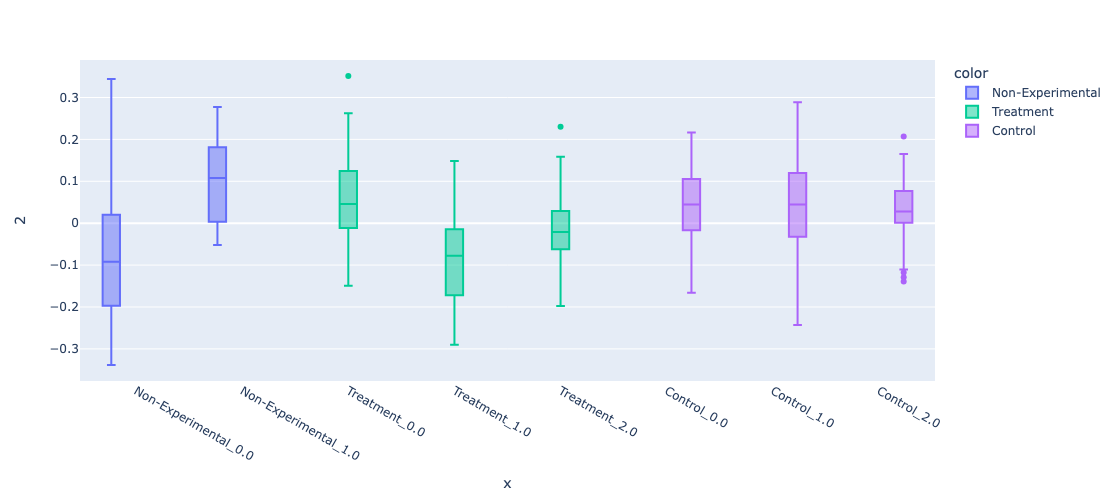

In [78]:
px.box(DCM, x=doc.treatment_by_session, y=2, height=500, color=doc.treatment_status)

/Users/steffenerickson/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:1265: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



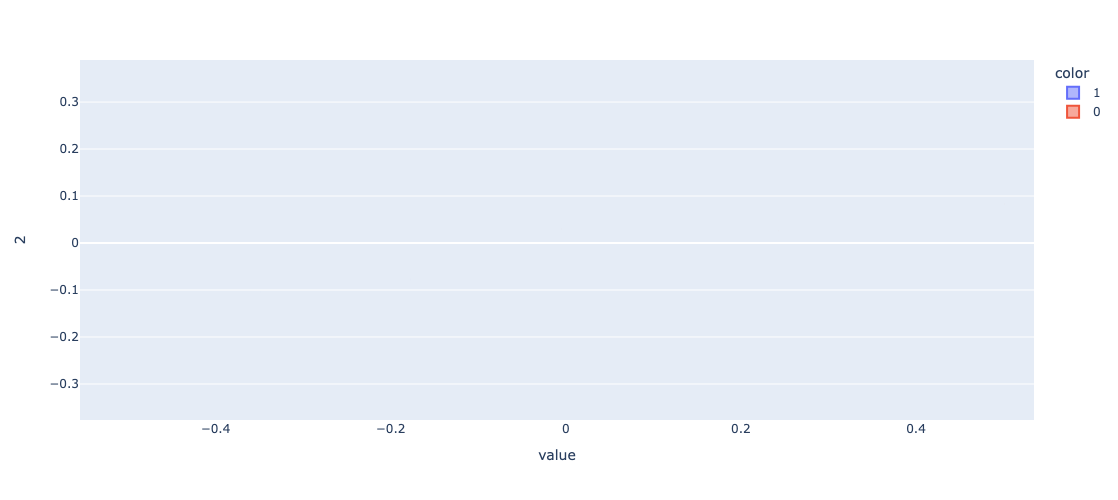

In [79]:
px.box(DCM, x=doc.score_above_mean, y=2, height=500, color=doc.score_above_mean)

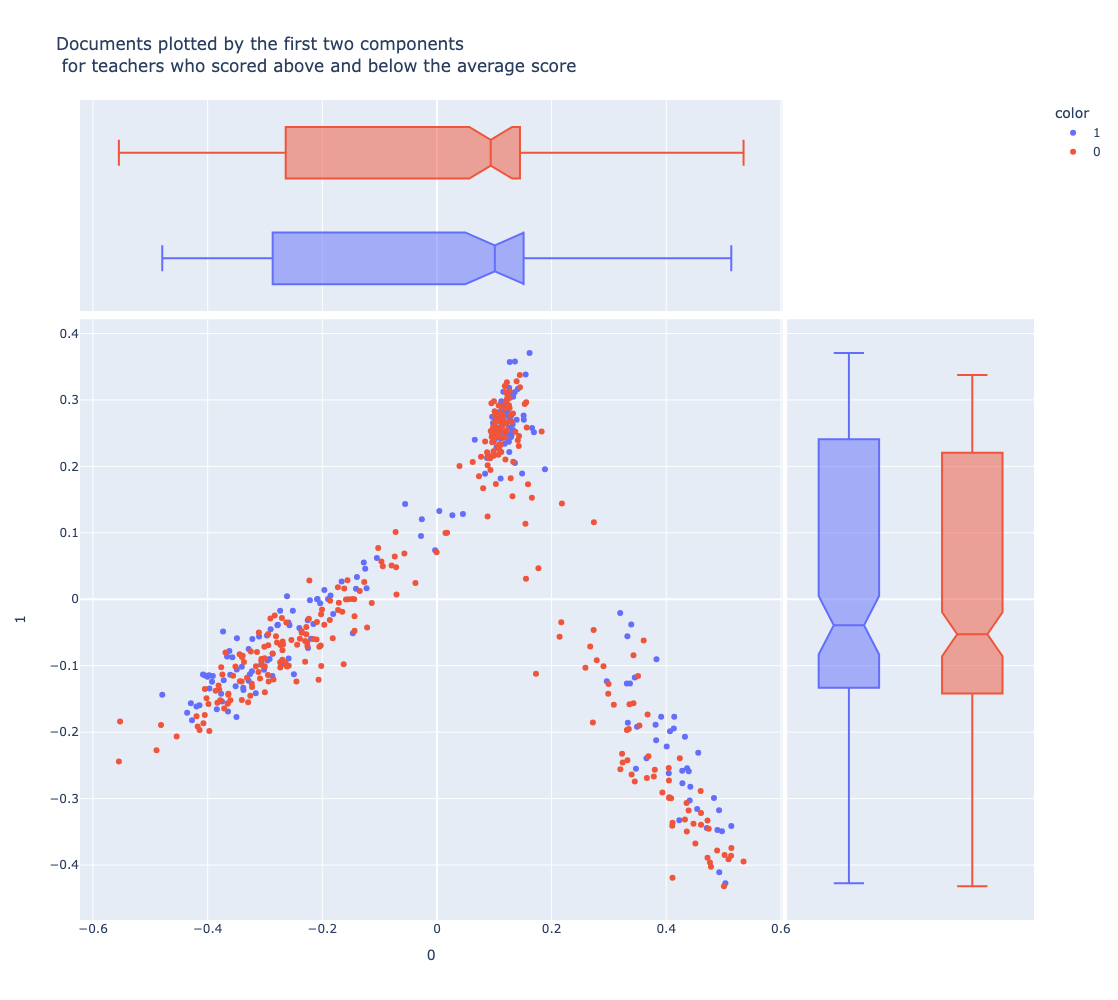

In [80]:
px.scatter(DCM, 0, 1, 
           color=doc.score_above_mean, 
           hover_name=doc.score_above_mean, 
           marginal_x='box', marginal_y='box', height=1000, title = "Documents plotted by the first two components <br> for teachers who scored above and below the average score")

In [81]:
fig = px.scatter(DCM, 0, 1, 
           color=doc.score_above_mean, 
           hover_name=doc.score_above_mean, 
           marginal_x='box', marginal_y='box', height=1000, title = "Documents plotted by the first two components <br> for teachers who scored above and below the average score")

fig.write_image(f"{output_dir}/01_figures/pca_visualization1_dcm.png")

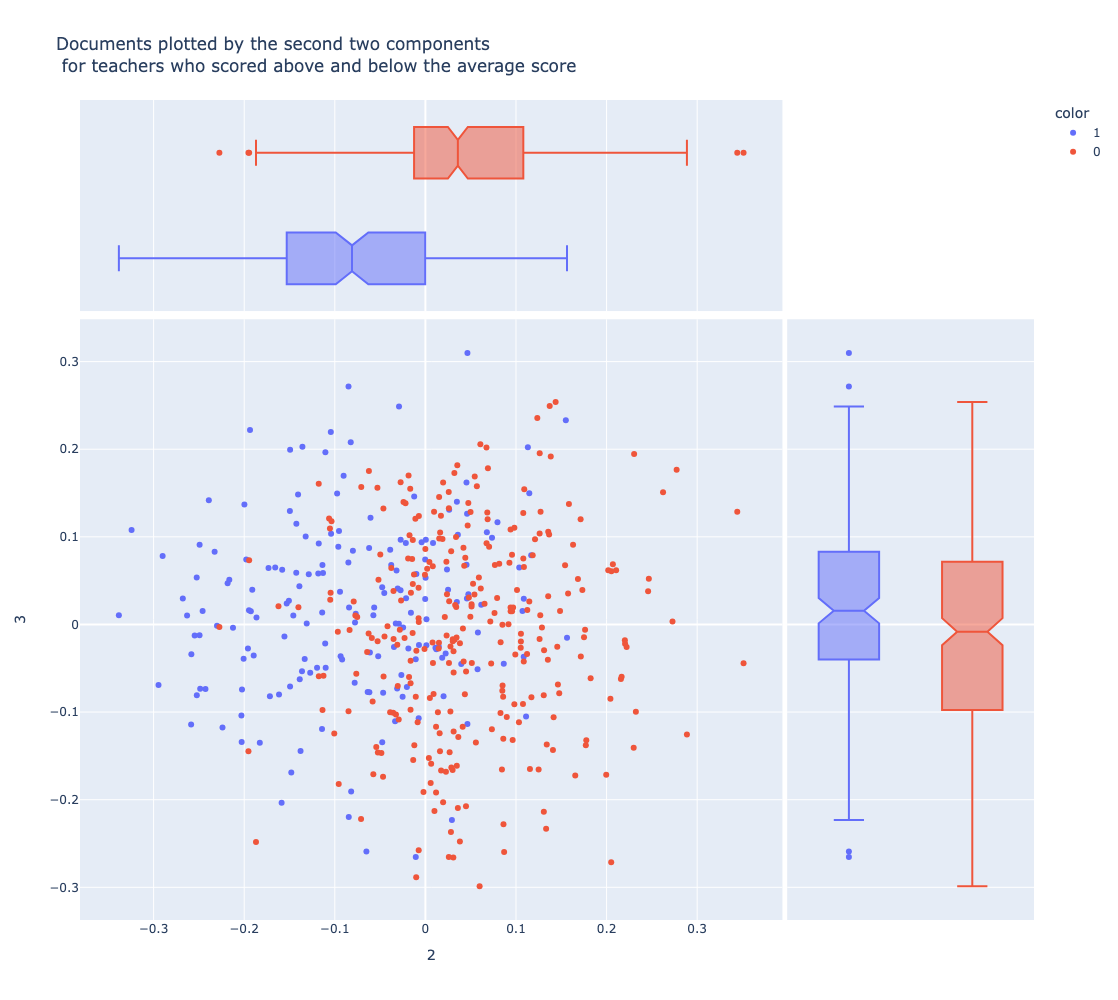

In [82]:
px.scatter(DCM, 2, 3, 
           color=doc.score_above_mean, 
           hover_name=doc.score_above_mean, 
           marginal_x='box', marginal_y='box', height=1000 , title = "Documents plotted by the second two components <br> for teachers who scored above and below the average score")

In [83]:
fig = px.scatter(DCM, 2, 3, 
           color=doc.score_above_mean, 
           hover_name=doc.score_above_mean, 
           marginal_x='box', marginal_y='box', height=1000, title = "Documents plotted by the second two components <br> for teachers who scored above and below the average score")

fig.write_image(f"{output_dir}/01_figures/pca_visualization2_dcm.png")

### Loadings Visualizations 

In [84]:
pos_list = "NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS".split()

In [85]:
VIDX = vocab[vocab.max_pos.isin(pos_list)].sort_values('dfidf', ascending=False).head(1000).index

In [86]:
vocab['df'] = dtcm.astype('bool').sum()

In [87]:
vocab

,n,p,i,n_chars,max_pos_group,max_pos,n_pos_group,cat_pos_group,n_pos,cat_pos,stop,porter_stem,dfidf,mean_tfidf,df
term_str,,,,,,,,,,,,,,,
to,20721,0.035155,4.830128,2,TO,TO,1,{'TO'},1,{'TO'},1,to,35.650945,0.021772,1066.0
we,20066,0.034044,4.876469,2,PR,PRP,1,{'PR'},1,{'PRP'},1,we,62.180973,0.038507,1047.0
so,19632,0.033307,4.908015,2,RB,RB,4,"{'NN', 'IN', 'RB', 'VB'}",9,"{'IN', 'NN', 'NNPS', 'NNP', 'VB', 'VBD', 'VBP'...",1,so,32.829738,0.019489,1068.0
the,19499,0.033082,4.917822,3,DT,DT,1,{'DT'},1,{'DT'},1,the,38.466740,0.023090,1064.0
i,15502,0.026300,5.248767,1,PR,PRP,6,"{'IN', 'NN', 'PR', 'VB', 'JJ', 'RB'}",9,"{'IN', 'NN', 'PRP', 'VB', 'JJ', 'VBP', 'RB', '...",1,i,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
jr,1,0.000002,19.168934,2,NN,NNP,1,{'NN'},1,{'NNP'},0,jr,10.091435,0.000280,1.0
reaches,1,0.000002,19.168934,7,VB,VBZ,1,{'VB'},1,{'VBZ'},0,reach,10.091435,0.000280,1.0
courthouses,1,0.000002,19.168934,11,NN,NNS,1,{'NN'},1,{'NNS'},0,courthous,10.091435,0.000280,1.0


In [88]:
keep = "n max_pos df dfidf".split()
vocabvis = vocab[keep]

In [89]:
vocabvis.loc[VIDX]

,n,max_pos,df,dfidf
term_str,,,,
put,836,VB,404.0,579.022457
says,774,VBZ,398.0,579.014685
looking,827,VBG,395.0,578.961985
solve,998,VB,408.0,578.956098
total,1189,JJ,392.0,578.876413
...,...,...,...,...
fours,9,NNS,8.0,56.731483
task,8,NN,1091.0,56.731483
activity,8,NN,8.0,56.731483


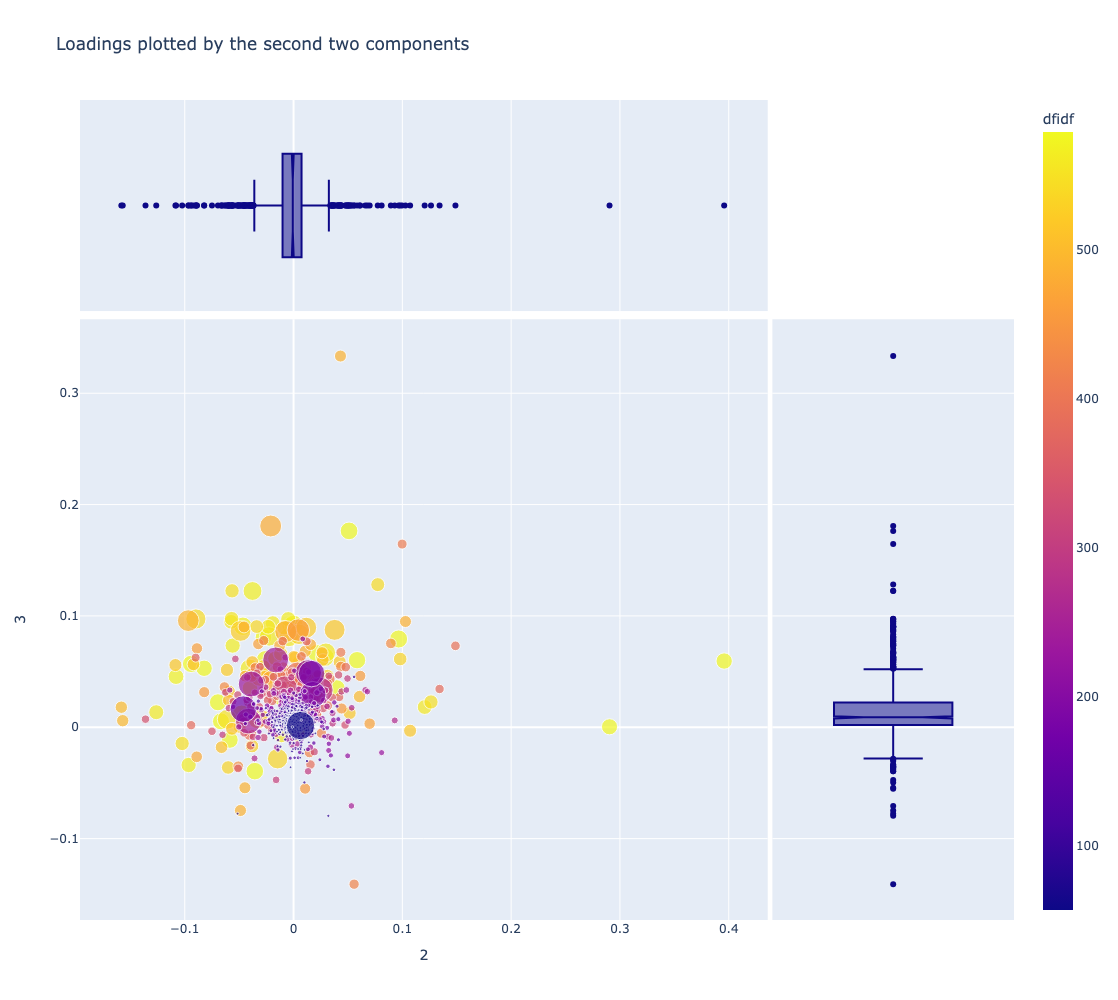

In [90]:
px.scatter(LOADINGS.join(vocabvis).reset_index(), 2, 3, hover_name='term_str', 
           size='df', color='dfidf',
           marginal_x='box', marginal_y='box', height=1000,
          title = "Loadings plotted by the second two components")

In [91]:
fig = px.scatter(LOADINGS.join(vocabvis).reset_index(), 0, 1, hover_name='term_str', 
           size='df', color='dfidf',
           marginal_x='box', marginal_y='box', height=1000,
          title = "Loadings plotted by the first two components")

fig.write_image(f"{output_dir}/01_figures/pca_visualization1_loadings.png")

In [92]:
fig = px.scatter(LOADINGS.join(vocabvis).reset_index(), 2, 3, hover_name='term_str', 
           size='df', color='dfidf',
           marginal_x='box', marginal_y='box', height=1000,
          title = "Loadings plotted by the second two components")
fig.write_image(f"{output_dir}/01_figures/pca_visualization2_loadings.png")